# Adversarial Inverse Reinforcement Learning for Market Making (2024)

This notebook contains the code for the paper _Adversarial Inverse Reinforcement Learning for Market Making_ published in the proceedings of the [ICAIF'24](https://ai-finance.org/) conference.

In [1]:
# TODO: Add a more detailed description of the script

In [2]:
import os
import time
from datetime import datetime

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data import rollout, serialize
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy
from tqdm import tqdm

from src.data import download_data, get_list_of_dates_between
from src.lob.commissions import BitCommissions
from src.lob.exchange import Exchange
from src.lob.plots import set_plot_style, visualize_backtest
from src.lob.traders import RLMarketMaker
from src.lob.utils import get_lot_size, get_tick_size
from src.rl.environments import LimitOrderBookGym
from src.rl.experts import ExpertPolicyV1, RandomPolicyV1
from src.rl.plotting import visualize_airl_train_stats
from src.rl.rewards import NegativeRewardNet
from src.rl.utils import load_model, save_model

In [3]:
# Set plot style
set_plot_style()

# Set device
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Set strict error checking
th.autograd.set_detect_anomaly(True)
np.seterr(all="raise")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
# Seed for the pseudo random generator
# SEED = 1
# SEED = 2
# SEED = 3
# SEED = 4
SEED = 5

In [6]:
# Set the (relative) paths to data directories
PATH = "data/pricing/"
PATH_MODELS = "data/models"
PATH_ROLLOUTS = "data/rollouts/"
PATH_VOL_DISTR = "data/volume_distributions/"

# Ensure directories exist
os.makedirs(PATH, exist_ok=True)
os.makedirs(PATH_MODELS, exist_ok=True)
os.makedirs(PATH_ROLLOUTS, exist_ok=True)
os.makedirs(PATH_VOL_DISTR, exist_ok=True)

In [7]:
# Enable/disable long print outputs
PRINT = False

# Section 1: Limit order book data preprocessing

In this section, we download and preprocess the limit order book and trades data for the training and testing of the AIRL market making agent.

<font color='orange'>**Remark:**</font> As discussed in the paper, for the research and demonstration of the AIRL algorithm we get the data from the [Crypto Lake](https://crypto-lake.com/) data provider. For the SOL-USD there is data available from the smaller crypto exchange BIT.COM. Note that since the focus of the paper was the demonstration of the new AIRL approach, we only do a simple preprocessing of the data. For a real-world market making application, more sophisticated data preprocessing and live exchange analysis (e.g. real exchange volumes, detection of fake trades, latency measurements, API limits,  etc.) would be necessary.

### 1.1. Data download

Firstly, the limit order book and trade data are downloaded from the [Crypto Lake](https://crypto-lake.com/) data provider.

<font color='orange'>**Remark:**</font> In order to download the data, it is required to have an active [subscription](https://crypto-lake.com/subscribe/).

In [8]:
# Set the parameters
exchange = "BIT.COM"
symbol = "SOL-USDT"
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 13)

In [9]:
# Generate a list of dates
dates = get_list_of_dates_between(start_date, end_date)

In [ ]:
# Download the data
for date in tqdm(dates):
    download_data(date, symbol, exchange, "book", PATH)  # LOB data
    download_data(date, symbol, exchange, "trades", PATH)  # Trade data

### 1.2. Visualize the bid-ask prices

In this subsection, we visualize the bid-ask prices for different limit order book levels. As can be seen from the visualizations below, there are multiple timestamps with wide quoted spreads.

These timestamps are filtered out from the dataset in the next subsection to worsen the market maker's performance. A more detailed analysis would be needed to determine whether such spreads could be captured by the market maker.

In [11]:
# Set the parameters
exchange = "BIT.COM"
symbol = "SOL-USDT"
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 13)

In [12]:
# Load the order book data from parquet files
ob_prefix = f"{exchange}_{symbol}_order_book"

# Generate a list of dates
dates = get_list_of_dates_between(start_date, end_date)

# Create a single joined dataframe with order book data
df_joined = None
for date in dates:
    file_name = f"{ob_prefix}_{date.strftime('%Y_%m_%d')}_original.parquet"
    df = pd.read_parquet(os.path.join(PATH, file_name))
    if df_joined is None:
        df_joined = df
    else:
        df_joined = pd.concat([df_joined, df])

df_joined.sort_index(inplace=True)

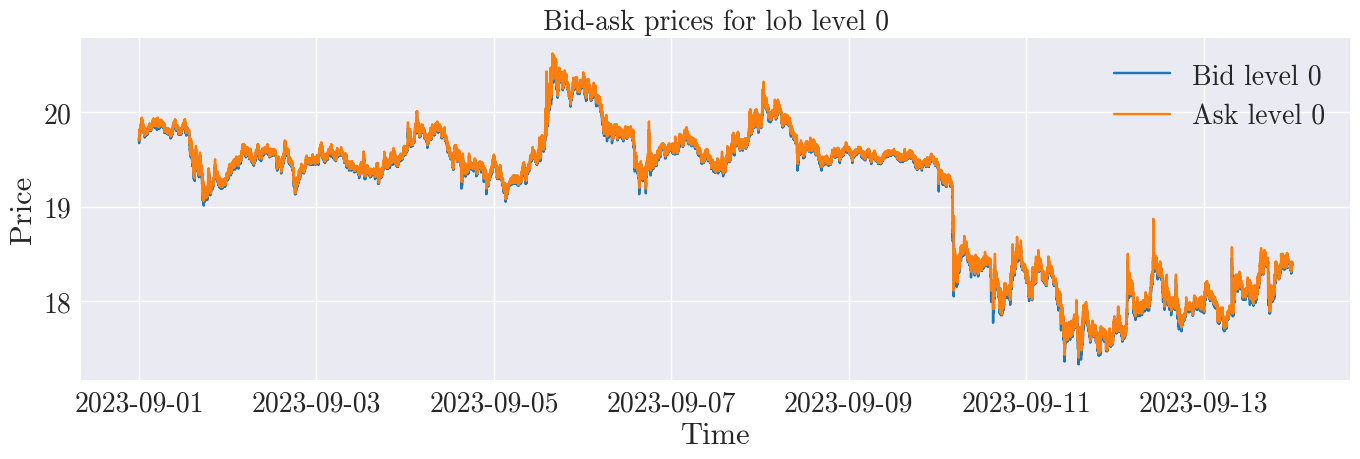

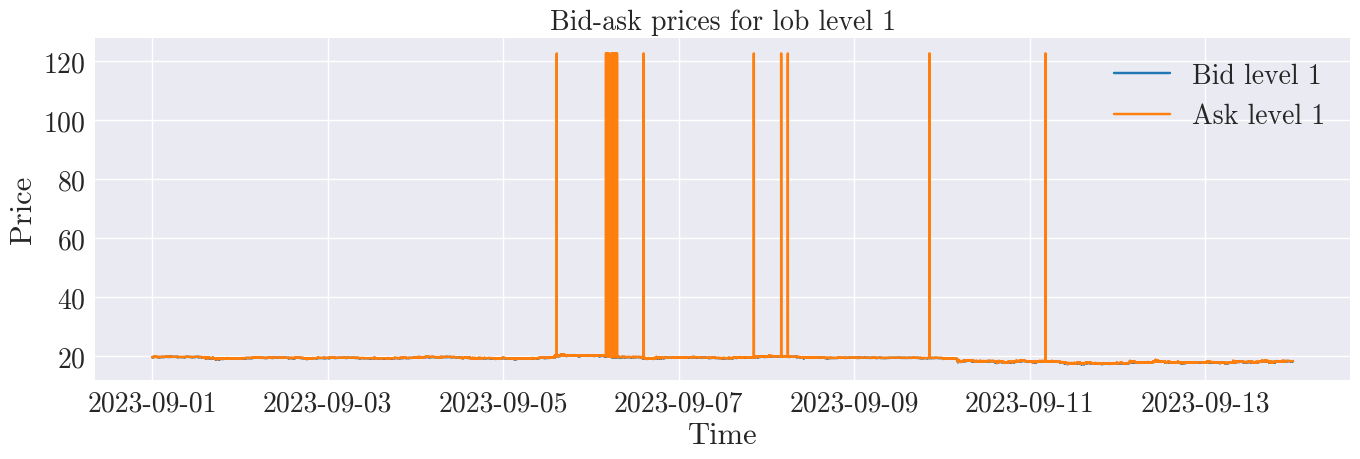

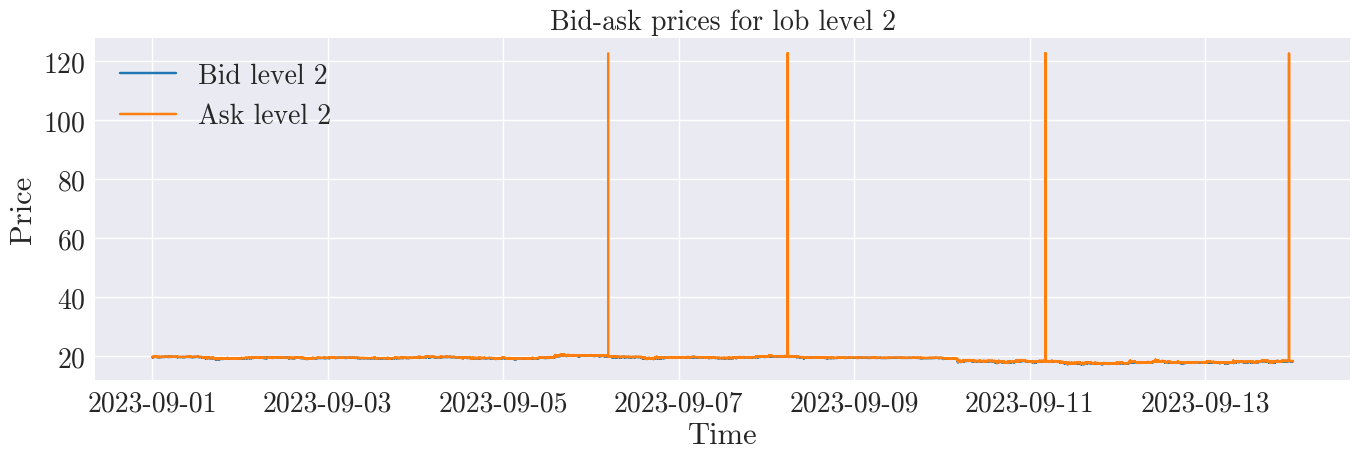

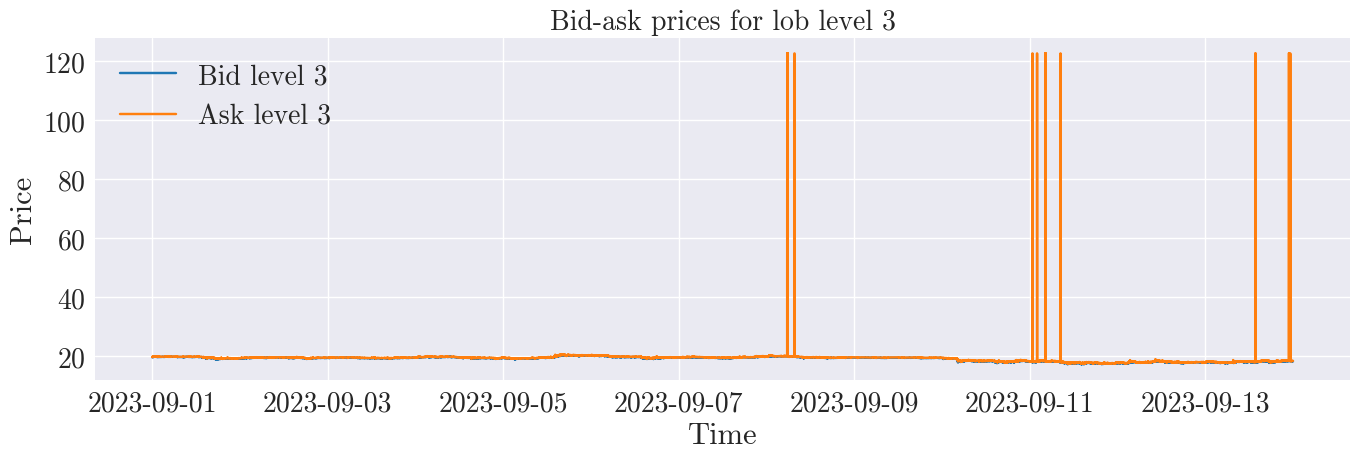

In [13]:
# Visualize the bid-ask prices for each limit order book level
for level in range(4):
    fig = plt.figure(figsize=(14, 5))
    plt.plot(df_joined[f"bid_{level}_price"], label=f"Bid level {level}")
    plt.plot(df_joined[f"ask_{level}_price"], label=f"Ask level {level}")
    plt.title(f"Bid-ask prices for lob level {level}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 1.3. Data cleaning

In this section, we filter out the timestamps with the outlier spreads visualized in the previous section. Since the focus of the paper is on the market making strategy quoting limit orders, this assumption does not improve the backtest performance as the market making agent does not have the possibility to quote limit orders at the prices with these large spreads.

In [14]:
df_joined = None

for date in dates:
    # Load the dataframe
    file_name = f"{ob_prefix}_{date.strftime('%Y_%m_%d')}_original.parquet"
    df = pd.read_parquet(os.path.join(PATH, file_name))

    # Print the number of rows to be filtered
    threshold = 30
    a = df["ask_0_price"] > threshold
    b = df["ask_1_price"] > threshold
    c = df["ask_2_price"] > threshold
    print(
        f"Date: {date} -",
        f"Rows to be filtered: {df[a | b | c].shape[0]} out of {df.shape[0]}",
        f"({df[a | b | c].shape[0] / df.shape[0] * 100:.2f}%)",
    )

    # Remove outliers
    new_df = df[df["ask_0_price"] < threshold]
    new_df = new_df[new_df["ask_1_price"] < threshold]
    new_df = new_df[new_df["ask_2_price"] < threshold]
    new_df = new_df[new_df["ask_3_price"] < threshold]

    # Save the cleaned dataframe
    new_file_name = f"{ob_prefix}_{date.strftime('%Y_%m_%d')}.parquet"
    new_df.to_parquet(os.path.join(PATH, new_file_name))

    # Join the dataframes
    if df_joined is None:
        df_joined = new_df
    else:
        df_joined = pd.concat([df_joined, new_df])

df_joined.sort_index(inplace=True)

Date: 2023-09-01 00:00:00 - Rows to be filtered: 0 out of 7014 (0.00%)
Date: 2023-09-02 00:00:00 - Rows to be filtered: 0 out of 7577 (0.00%)
Date: 2023-09-03 00:00:00 - Rows to be filtered: 0 out of 6754 (0.00%)
Date: 2023-09-04 00:00:00 - Rows to be filtered: 0 out of 7383 (0.00%)
Date: 2023-09-05 00:00:00 - Rows to be filtered: 1 out of 8767 (0.01%)
Date: 2023-09-06 00:00:00 - Rows to be filtered: 39 out of 8149 (0.48%)
Date: 2023-09-07 00:00:00 - Rows to be filtered: 3 out of 7168 (0.04%)
Date: 2023-09-08 00:00:00 - Rows to be filtered: 231 out of 9118 (2.53%)
Date: 2023-09-09 00:00:00 - Rows to be filtered: 9 out of 6144 (0.15%)
Date: 2023-09-10 00:00:00 - Rows to be filtered: 0 out of 8583 (0.00%)
Date: 2023-09-11 00:00:00 - Rows to be filtered: 39 out of 11291 (0.35%)
Date: 2023-09-12 00:00:00 - Rows to be filtered: 0 out of 10089 (0.00%)
Date: 2023-09-13 00:00:00 - Rows to be filtered: 423 out of 12495 (3.39%)


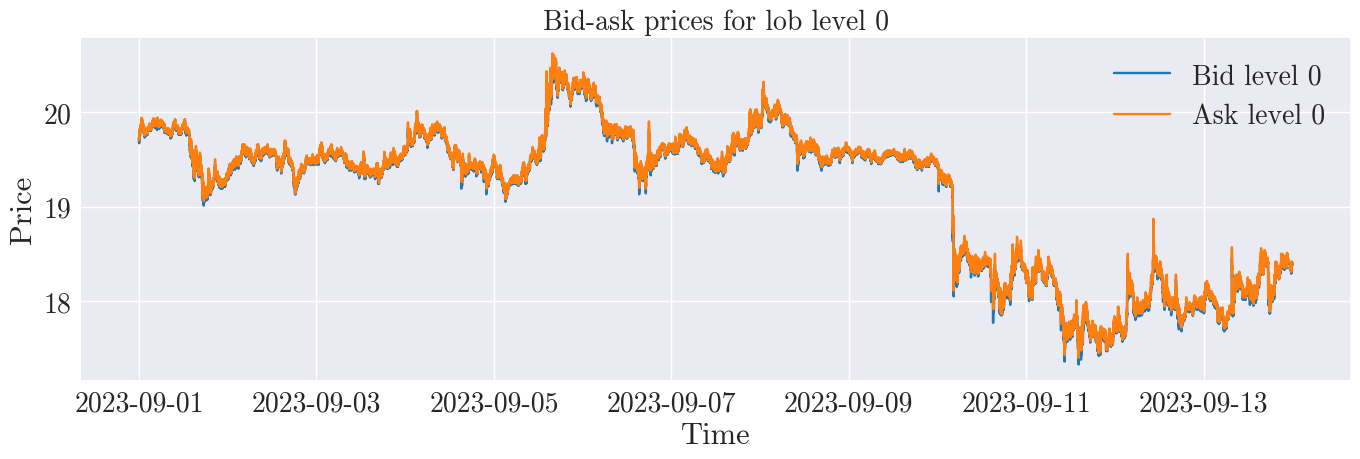

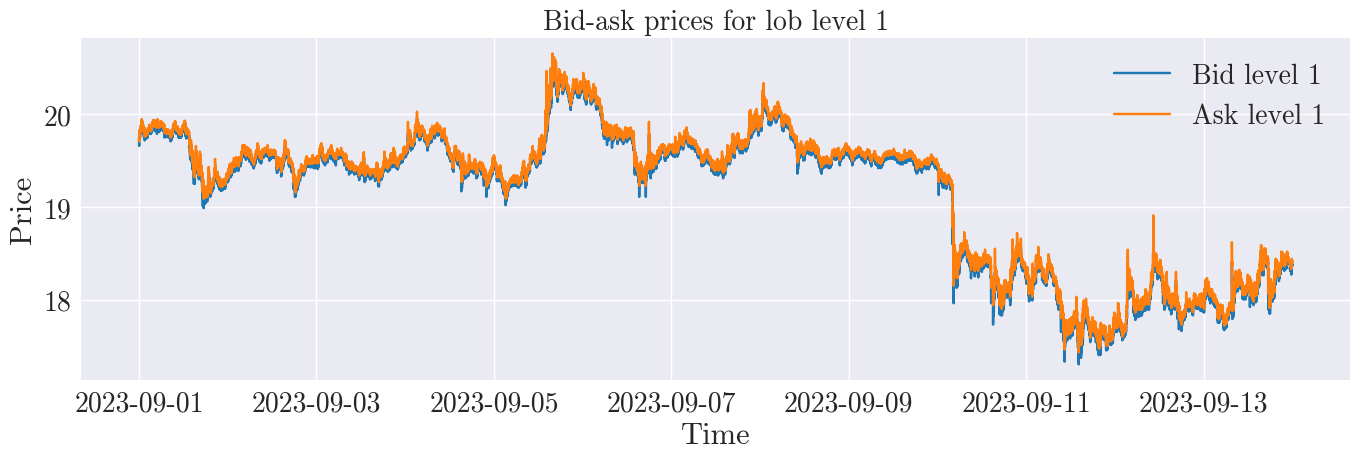

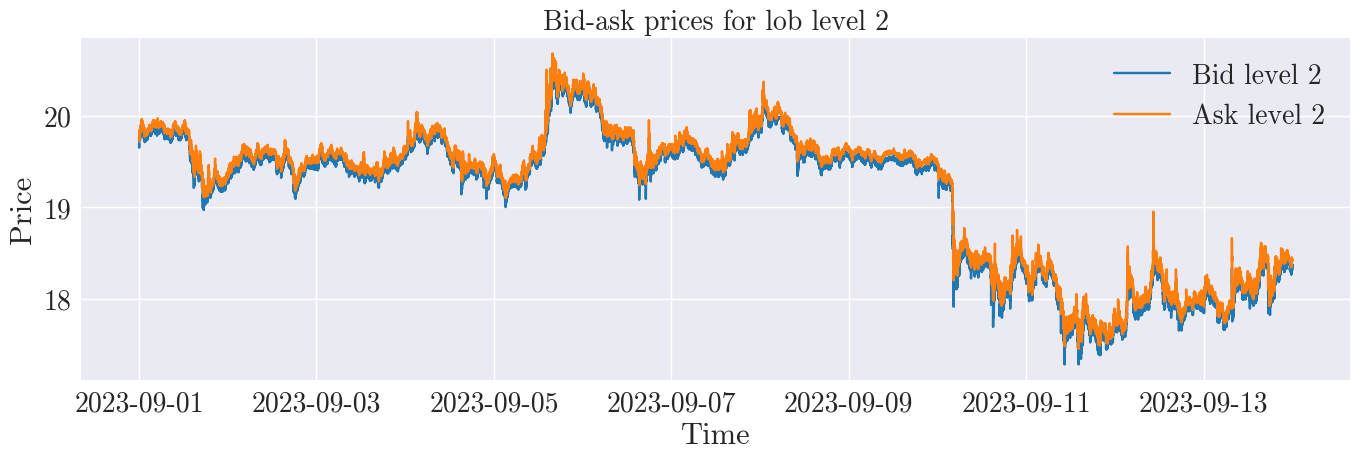

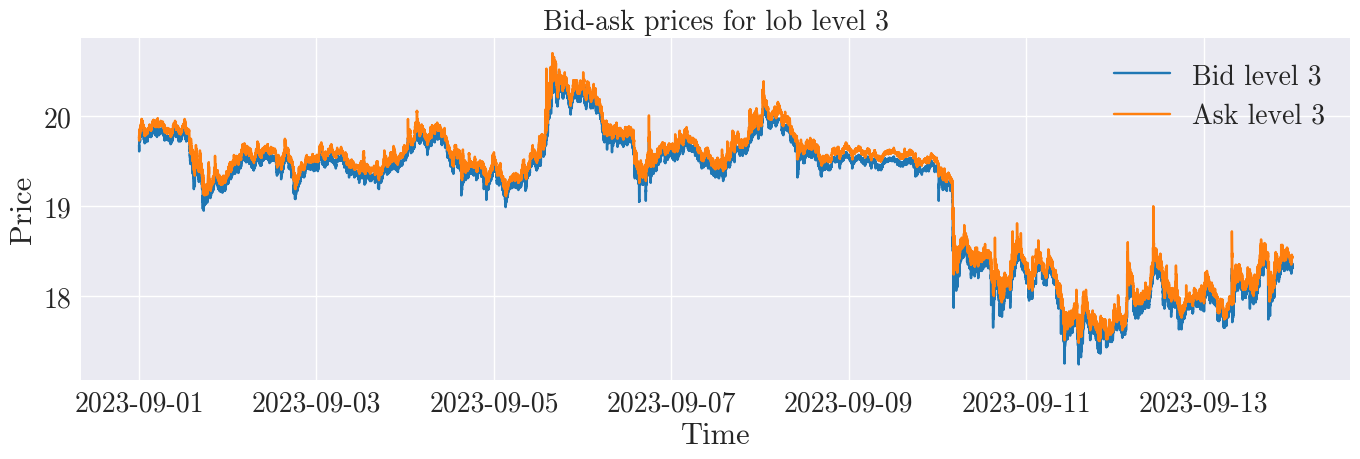

In [15]:
# Visualize the bid-ask prices for each limit order book level (after cleaning)
for level in range(4):
    fig = plt.figure(figsize=(14, 5))
    plt.plot(df_joined[f"bid_{level}_price"], label=f"Bid level {level}")
    plt.plot(df_joined[f"ask_{level}_price"], label=f"Ask level {level}")
    plt.title(f"Bid-ask prices for lob level {level}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

The outlier spreads are now removed from the data and the cleaned data are used for the training of the market making agent.

### 1.3. Generate volume distributions

Here, we generate the empirical volume distributions at each limit order book level. These empirical volume distributions are later used in the stochastic backtest simulator to sample the volumes of the penalizing front-running orders which worsen the priority of the market making agent's orders.

In [16]:
# Set the new dates (Use only insample data for training)
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 10)

In [17]:
# Ensure the volume distributions directory exists
os.makedirs(PATH_VOL_DISTR, exist_ok=True)

In [18]:
# Load the order book data from parquet files
ob_prefix = f"{exchange}_{symbol}_order_book"

# Generate a list of dates
dates = get_list_of_dates_between(start_date, end_date)

# Create a single joined dataframe with order book data
df_joined = None
for date in dates:
    file_name = f"{ob_prefix}_{date.strftime('%Y_%m_%d')}.parquet"
    df = pd.read_parquet(os.path.join(PATH, file_name))
    if df_joined is None:
        df_joined = df
    else:
        df_joined = pd.concat([df_joined, df])

df_joined.sort_index(inplace=True)

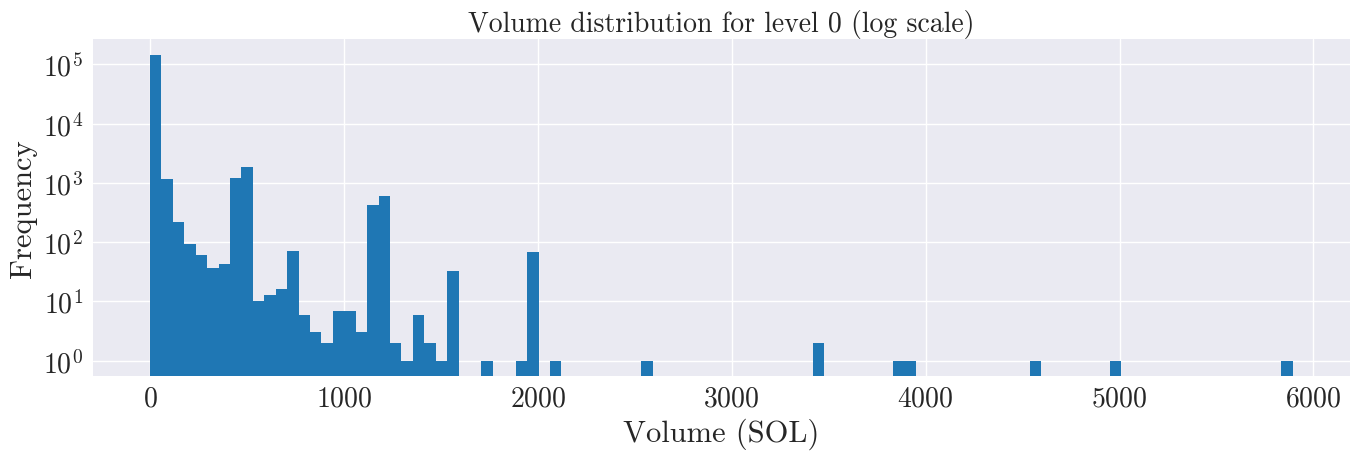

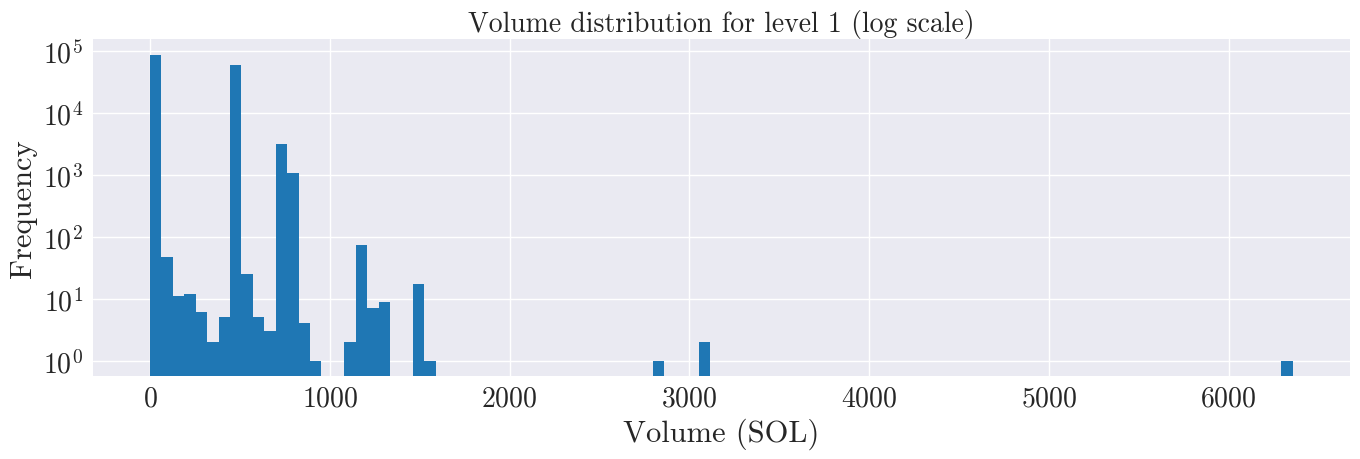

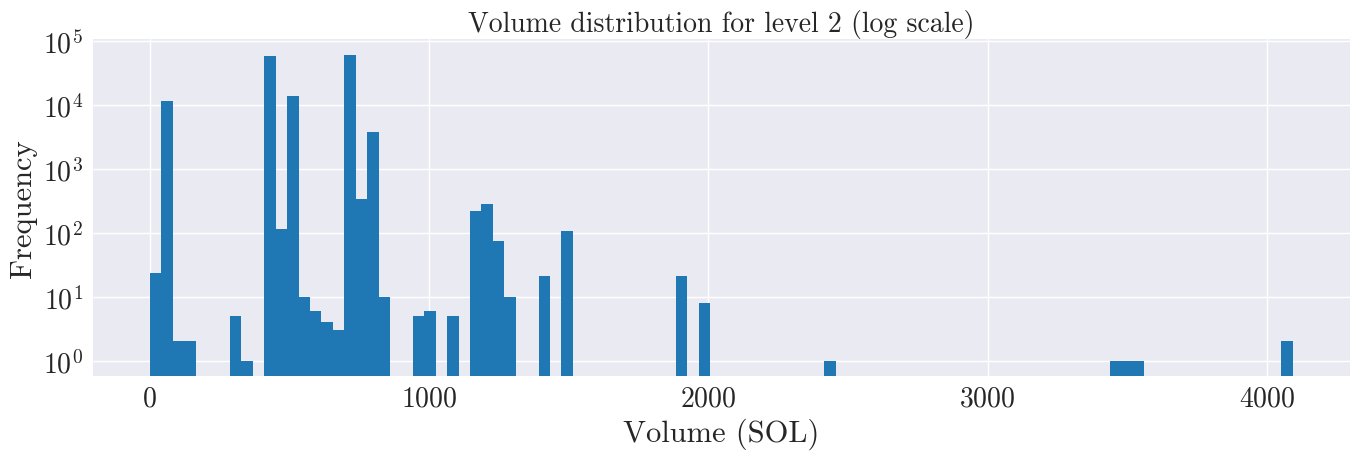

In [19]:
for level in range(3):
    # Join the bid and ask volumes
    vols_level = list(df_joined[f"bid_{level}_size"].values) + list(
        df_joined[f"ask_{level}_size"].values
    )

    # Visualize the volume distribution
    fig = plt.figure(figsize=(14, 5))
    plt.hist(vols_level, bins=100, log=True)
    plt.xlabel("Volume (SOL)")
    plt.ylabel("Frequency")
    plt.title(f"Volume distribution for level {level} (log scale)")
    plt.tight_layout()
    plt.show()

In [20]:
# Generate and save the volume distributions. This distributions are later
# loaded and sampled from in the stochastical backtests.
for level in range(3):
    # Join the bid and ask volumes
    vols_level = pd.Series(
        list(df_joined[f"bid_{level}_size"].values)
        + list(df_joined[f"ask_{level}_size"].values)
    )

    # Save the volume distribution
    save_path = os.path.join(PATH_VOL_DISTR, f"volumes_level_{level}.pkl")
    vols_level.to_pickle(save_path)

# Section 2: Pre-generate expert trajectories

In the second section, we pre-generate the expert trajectories using the previously downloaded limit order book data. The expert trajectories are generated by simulating the expert-like market making agent's actions in the backtest simulator. These expert trajectories are later used in the adversarial inverse reinforcement learning algorithm to train the discriminator (or reward neural network) for distinguishing the expert trajectories from the adversarial agent's trajectories.

### 2.1. Register custom vectorized environment

Firstly, we need to load and register our custom limit order book environment as a custom gym vectorized environment. This is necessary for the `stable-baselines3` library to work with the environment.

In [21]:
# Set the parameters
EXCHANGE_NAME = "BIT.COM"
SYMBOL = "SOL-USDT"
TICK_SIZE = get_tick_size(EXCHANGE_NAME)  # Tick size of the limit order book
LOT_SIZE = get_lot_size(EXCHANGE_NAME)  # Lot size of the limit order book
DEPTH = 20  # Depth of the data to load to the limit order book (max 20)
EXCHANGE_TRADER_ID = "Exchange"
MAX_STEPS = 300  # Maximum number of steps in an episode
TS_START = pd.Timestamp("2023-09-01 00:00:00")  # Start of the episode
TS_END = pd.Timestamp("2023-09-10 23:59:59")  # End of the episode
DETERMINISTIC = False  # Indicates whether to use a deterministic environment
WIN = 0  # Window size for the features computation
LOGGING = False  # Indicates whether to log events
TS_SAVE = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving
LATENCY_COMP_PARAMS = {}  # Parameters for the stochastic backtest
RNG = np.random.default_rng(seed=SEED)  # Random number generator
traders = {}  # Dictionary of traders

print("Timestamp for saving: ", TS_SAVE)

Timestamp for saving:  2024-11-04_21-47-56


In [22]:
# Set the parameters for the RL agent
rl_trader_id = "RLMarketMaker"
com_model = BitCommissions(tier=5)
volume = 100

# Initialize the trader
trader = RLMarketMaker(
    id=rl_trader_id,
    com_model=com_model,
    volume=volume,
)
traders[rl_trader_id] = trader

# Write a description of the experiment
description = "RL market maker simulation."

In [23]:
# Set the parameters for the environment
ID = "LimitOrderBookGym-v1"
ENTRY_POINT = LimitOrderBookGym
KWARGS = {
    "exchange_name": EXCHANGE_NAME,
    "symbol_name": SYMBOL,
    "tick_size": TICK_SIZE,
    "lot_size": LOT_SIZE,
    "depth": DEPTH,
    "traders": traders,
    "max_steps": MAX_STEPS,
    "ts_start": TS_START,
    "ts_end": TS_END,
    "deterministic": DETERMINISTIC,
    "win": WIN,
    "path": PATH,
    "path_vol_distr": PATH_VOL_DISTR,
    "rl_trader_id": rl_trader_id,
    "latency_comp_params": LATENCY_COMP_PARAMS,
    "logging": LOGGING,
    "ts_save": TS_SAVE,
    "description": description,
    "rng": RNG,
}

# Register the environment
gym.envs.register(
    id=ID,
    entry_point=ENTRY_POINT,
    kwargs=KWARGS,
    max_episode_steps=MAX_STEPS,
)

# Create the environment
env = Monitor(gym.make(ID))

# Save the saving ts
ts_save = env.unwrapped.exchange.ts_save
print(f"Saving ts: {ts_save}")

Saving ts: 2024-11-04_21-47-56


In [24]:
# Create the vectorized environment
venv = make_vec_env(
    ID,
    rng=RNG,
    n_envs=1,
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
    parallel=False,
)
venv = VecCheckNan(venv, raise_exception=True)  # Check for NaN observations
venv.reset()

array([[ 0.        , -0.12163741, -0.10920341, -0.18783693,  0.12163741,
         0.14130488,  0.15181272,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

### 2.2. Generate rollouts with random and expert policies

Next, we define an expert policy that will be used as a target for the adversarial agent. We use this expert policy to generate the expert trajectories for the AIRL algorithm. These trajectories are saved to the `data/rollouts` directory and loaded before training to save time in the training process. Alternatively, you can also generate these during the AIRL training process but this will take more time.

In [25]:
# Set the parameters for the rollout
min_timesteps = None
min_episodes = 1

# Rollout the environment with a random policy
rollouts = rollout.rollout(
    None,  # Random policy
    venv,
    sample_until=rollout.make_sample_until(
        min_timesteps=min_timesteps, min_episodes=min_episodes
    ),
    rng=RNG,
)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        print("Observation: ", rollouts[0].obs[i])
        print("Action: ", rollouts[0].acts[i])
        print()

In [26]:
# Initialize the random policy
random_policy = RandomPolicyV1(venv.action_space)

# Evaluate the random policy
reward_random_policy, _ = evaluate_policy(
    random_policy, env, 1, return_episode_rewards=True
)
print("Reward: ", np.mean(reward_random_policy))
print("Std:    ", np.std(reward_random_policy))

Reward:  16.0
Std:     0.0


In [27]:
# Initialize the expert policy
expert = ExpertPolicyV1()

# Set the parameters for the rollout
min_timesteps = None
min_episodes = 1

# Rollout the environment with the expert policy
rollouts = rollout.rollout(
    expert.predict,
    venv,
    sample_until=rollout.make_sample_until(
        min_timesteps=min_timesteps, min_episodes=min_episodes
    ),
    rng=RNG,
)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        state, act = rollouts[0].obs[i][0], rollouts[0].acts[i]
        print(f"State 0: {state: .3f} --> Action: {act}")

In [28]:
# Flatten the trajectories into transitions
transitions = rollout.flatten_trajectories(rollouts)
if PRINT:
    print("Transitions: ", transitions)

In [29]:
# Evaluate the expert
reward_expert_policy, _ = evaluate_policy(
    expert, venv, 1, return_episode_rewards=True
)
print("Reward: ", np.mean(reward_expert_policy))
print("Std:    ", np.std(reward_expert_policy))

Reward:  300.0
Std:     0.0


In [30]:
# Load or generate larger sample of expert trajectories.
# These rollouts are later used to train the AIRL agent, in particular they are
# used to train its discriminator.
rollouts_file = os.path.join(PATH_ROLLOUTS, "rollouts.pkl")

# If the rollouts file exists load the rollouts
if os.path.exists(rollouts_file):
    rollouts = serialize.load(rollouts_file)

# Else, generate the rollouts
else:
    # Set the parameters for the rollout
    min_timesteps = 45000 * 3 + 4500
    min_episodes = None

    # Rollout the environment with the expert policy
    print("Generating rollouts... (Might take around 15 minutes.)")
    rollouts = rollout.rollout(
        expert.predict,
        venv,
        sample_until=rollout.make_sample_until(
            min_timesteps=min_timesteps, min_episodes=min_episodes
        ),
        rng=RNG,
    )

    # Ensure the directory exists and save the rollouts
    serialize.save(rollouts_file, rollouts)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        print("Observation: ", rollouts[0].obs[i])
        print("Action: ", rollouts[0].acts[i])
        print()

# Section 3: Training of the AIRL agent

In [31]:
# TODO: Description

### 3.1. Initialize the AIRL agent

In this section, we demonstrate a pipeline for training of the adversarial inverse reinforcement learning agent. The goal is to learn the reward function of the expert policy by training of the discriminator network and the agent policy network.

In [32]:
# Set parameters for PPO (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 10  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the current reward
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

In [33]:
# Set the parameters for the (negative) reward net
use_state = True  # Current state is used for the reward
use_action = True  # Current action is used for the reward
use_next_state = False  # Next state is used for the reward
use_done = False  # Done flag is used for the reward

In [34]:
# Set the parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing the issue with the NaNs

<font color='orange'>**Warning:**</font> Be careful when updateing the settings below. When changing them, use the multiples of episode length (otherwise you might run into unexpected issues with variable horizons during training).

In [35]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 600

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [36]:
# Initialize the learner policy
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=SEED,
    device=DEVICE,
)

In [37]:
# Initialize the custom reward network
reward_net = NegativeRewardNet(
    observation_space=venv.observation_space,
    action_space=venv.action_space,
    use_state=use_state,
    use_action=use_action,
    use_next_state=use_next_state,
    use_done=use_done,
)

In [38]:
# Initialize the AIRL trainer
airl_trainer = AIRL(
    demonstrations=rollouts,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [39]:
# Evaluate the policy before training
venv.seed(SEED)
learner_rewards_before_training, _ = evaluate_policy(
    learner, venv, 1, return_episode_rewards=True
)
print("Mean: ", np.mean(learner_rewards_before_training))
print("Std: ", np.std(learner_rewards_before_training))

Mean:  1.0
Std:  0.0


In [40]:
# Visualize actions of the policy before training
if PRINT:
    for _ in range(1):
        obs = venv.reset()
        done = False
        while not done:
            print(obs)
            action, _ = learner.predict(obs, deterministic=True)
            print(action)
            print()
            obs, _, done, _ = venv.step(action)

### 3.2. Train the AIRL agent

In [ ]:
# Train the model
airl_trainer.train(total_timesteps=total_timesteps)

### 3.3. Save the trained model and training statistics

Lastly, save the trained model and the training statistics for further analysis.

In [ ]:
# Save the model
save_path = os.path.join(os.getcwd(), "models")
ts = airl_trainer.ts_now
stats = airl_trainer.logger._logger.stats
save_model(learner, reward_net, stats, save_path, ts)
print(f"Saved the model with timestamp: {ts}")

# Section 4: Evaluation of the AIRL agent

### 4.1. Load the trained model

In [41]:
# Pick the timestamp of the model to load
# ts = "2024-01-21_17-12-35" # seed 1
# ts = "2024-01-22_18-03-01" # seed 2
# ts = "2024-01-23_19-14-27" # seed 3
# ts = "2024-01-24_09-40-47" # seed 4
ts = "2024-01-24_22-39-37"  # seed 5

In [42]:
# Load the model from the new path
learner, reward_net, stats = load_model(PATH_MODELS, ts)

/home/juraj/.cache/pypoetry/virtualenvs/airl-market-making-BPwY8dy3-py3.11/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:449: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

### 4.2. Evaluate the trained model

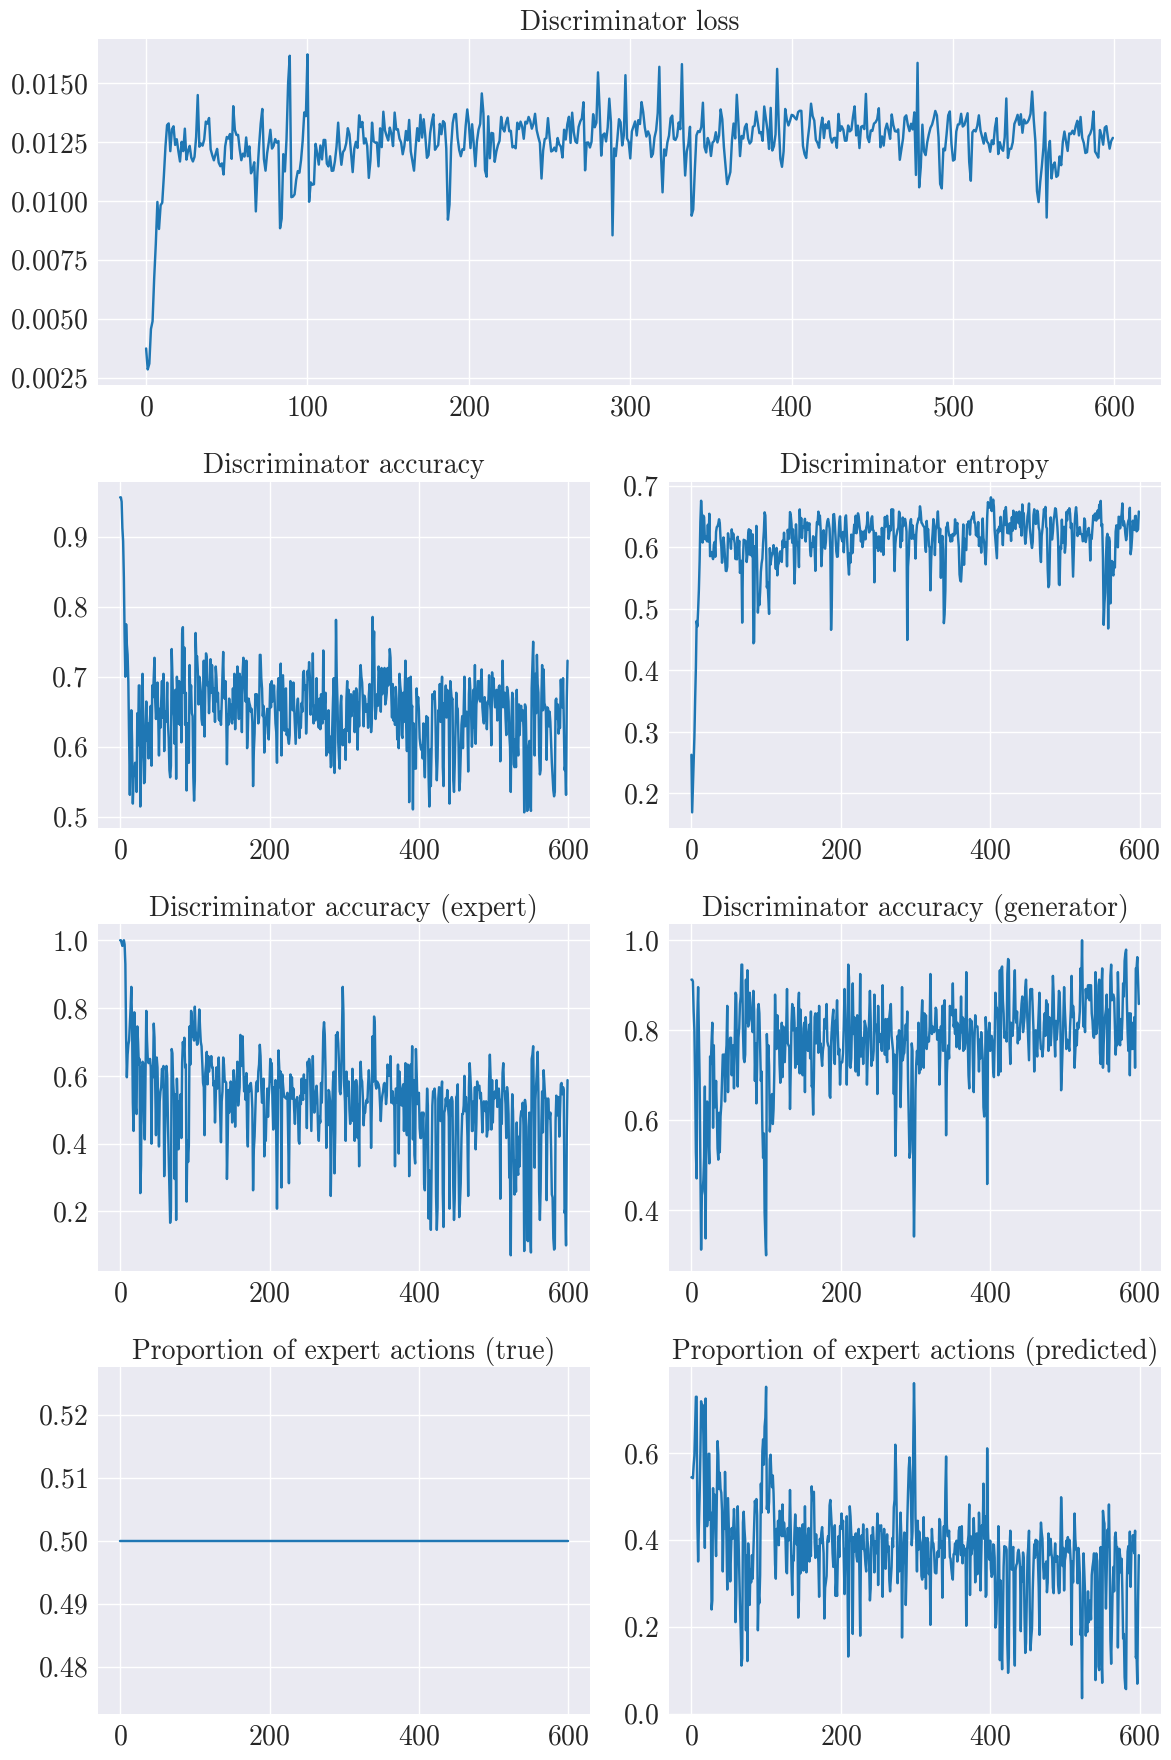

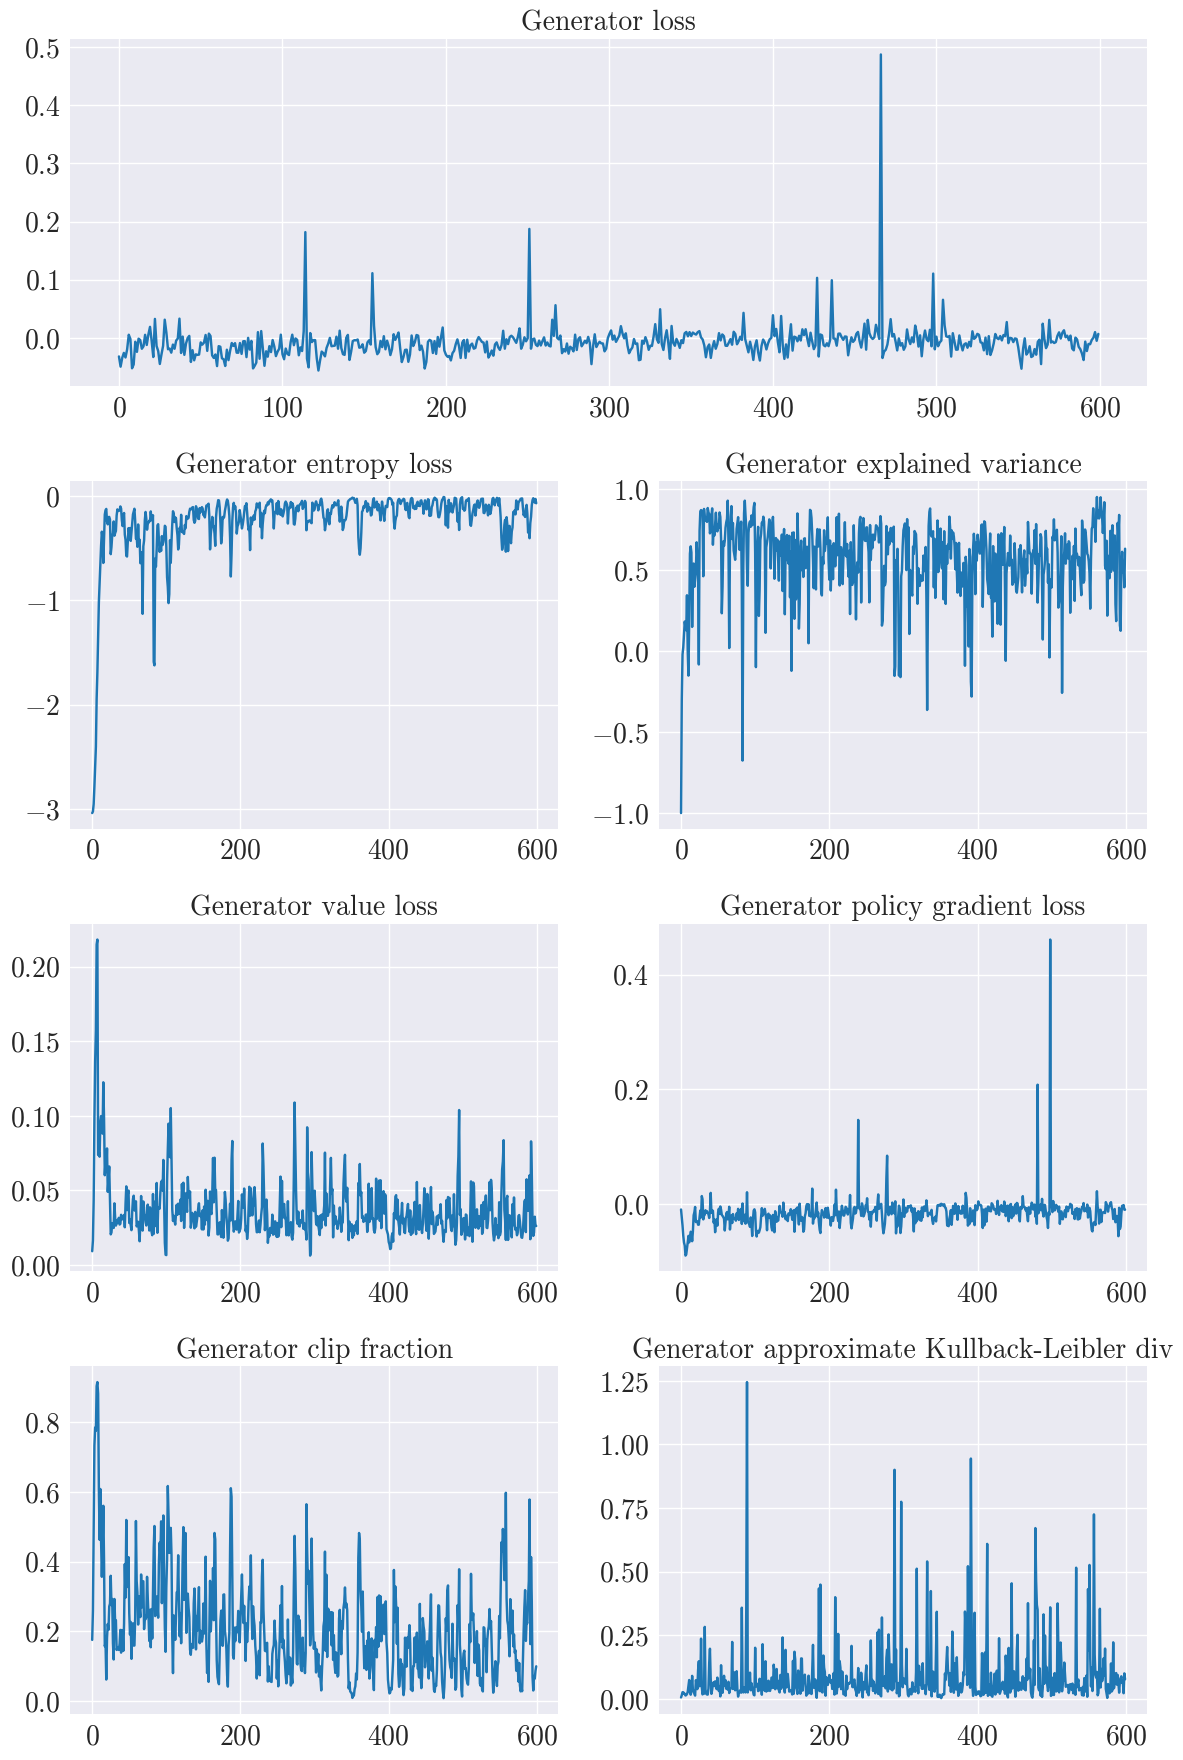

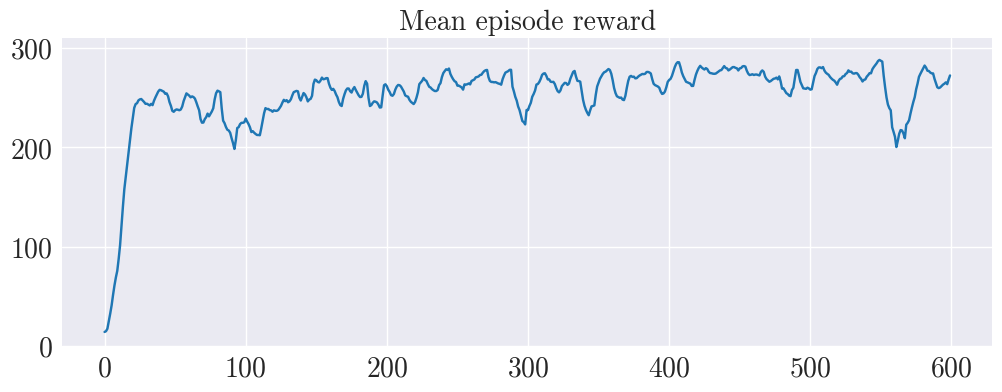

In [43]:
# Visualize the stats
save_fig = False
visualize_airl_train_stats(stats, save_fig=save_fig)

In [ ]:
# Evaluate the policy after training
venv.seed(SEED)
learner_rewards_after_training, _ = evaluate_policy(
    learner, venv, 5, return_episode_rewards=True
)
print("Mean: ", np.mean(learner_rewards_after_training))
print("Std: ", np.std(learner_rewards_after_training))

In [ ]:
# Visualize actions of the policy after training
if PRINT:
    for _ in range(1):
        obs = venv.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs, deterministic=True)
            print(f"Obs: {obs[0][0]: .5f} --> Action: {action}")
            obs, _, done, _ = venv.step(action)

### 4.3. Visualize the backtest results

In [ ]:
# Set the parameters
EXCHANGE_NAME = "BIT.COM"
SYMBOL = "SOL-USDT"
TICK_SIZE = get_tick_size(EXCHANGE_NAME)  # Tick size of the limit order book
LOT_SIZE = get_lot_size(EXCHANGE_NAME)  # Lot size of the limit order book
DEPTH = 20  # Depth of the data to load to the limit order book (max 20)
EXCHANGE_TRADER_ID = "Exchange"
MAX_STEPS = None  # Maximum number of steps in an episode
TS_START = pd.Timestamp("2023-09-11 00:00:00")  # Start of the episode
TS_END = pd.Timestamp("2023-09-13 23:59:59")  # End of the episode
WIN = 0  # Window size for the features computation
LOGGING = False  # Indicates whether to log events
LATENCY_COMP_PARAMS = {
    0: {"prob": 0.9, "divisor": 1},
    1: {"prob": 0.9, "divisor": 1},
    2: {"prob": 0.9, "divisor": 1},
    3: {"prob": 0.9, "divisor": 1},
}  # Latency compensation parameters for the stochastic backtest
RNG = np.random.default_rng(seed=SEED)  # Random number generator

In [ ]:
# Initialize the limit order book and traders
start = time.time()
traders = {}

# Behavior cloning agent
rl_trader_id = "RLMarketMaker"
com_model = BitCommissions(tier=5)
volume = 100
trader = RLMarketMaker(
    id=rl_trader_id,
    com_model=com_model,
    volume=volume,
    policy=learner.policy,
)
traders[rl_trader_id] = trader

description = "AIRL agent."

# Initialize the exchange
exchange = Exchange(
    exchange_name=EXCHANGE_NAME,
    symbol_name=SYMBOL,
    tick_size=TICK_SIZE,
    lot_size=LOT_SIZE,
    depth=DEPTH,
    traders=traders,
    max_steps=MAX_STEPS,
    ts_start=TS_START,
    ts_end=TS_END,
    win=WIN,
    path=PATH,
    path_vol_distr=PATH_VOL_DISTR,
    rl_trader_id=rl_trader_id,
    latency_comp_params=LATENCY_COMP_PARAMS,
    logging=LOGGING,
    ts_save=TS_SAVE,
    description=description,
    rng=RNG,
)
end = round(time.time() - start, 2)
print(f"Time taken for initialization of the exchange: {end} sec.")

# Run the exchange simulation
start = time.time()
exchange.run()
end = round(time.time() - start, 2)
print(f"Time taken for running the exchange: {end} sec.")

In [ ]:
# Visualize the backtest results
timestamps = exchange.stats["ts"]
trader_stats = traders[rl_trader_id].stats
initial_cost = 20.5 * volume * 2
visualize_backtest(timestamps, trader_stats, initial_cost)

# Section 5: Appendix (data analysis)